import all libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

# import the library we use to open URLs
import requests as r
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import the BeautifulSoup library so we can parse HTML and XML documents
!pip install BeautifulSoup4
from bs4 import BeautifulSoup

from bs4 import re
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

Let's get the wikipedia page content 

In [2]:
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_E'

In [3]:
page = r.get(url)
soup = BeautifulSoup(page.text, features ="html.parser")
#soup.prettify()

In [4]:
right_table=soup.find('table')
#right_table

In [5]:
Fred_df= pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
Fred_df

,PostalCode,Borough,Neighborhood


In [6]:
for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    for cell in cells:
        span= cell.findAll('span')
        
        PostalCode= span[0].find(text=True)
        a=span[0].findAll('a')
        if len(a)>0:
            Borough=a[0].find(text=True)
        else:
            Borough= 'Not Assigned'
        try:
            Neighborhood=re.search('</a><br/>(.+?)</span>',str(span[0])).group(1)
            end= Neighborhood.find('<br/>',0)
            if(end>= 0):
                Neighborhood=Neighborhood[0:end]
        except AttributeError:
            Neighborhood = 'Not Assigned' # apply your error handling
             
            
        Fred_df=Fred_df.append({'PostalCode':PostalCode,
                                 'Borough': Borough,
                                 'Neighborhood': Neighborhood                                      
                                }, ignore_index=True)
       

In [7]:
Fred_df.head()

,PostalCode,Borough,Neighborhood
0,E1A,Moncton,East
1,E2A,Bathurst,Not Assigned
2,E3A,Fredericton,North
3,E4A,Chipman,Not Assigned
4,E5A,Moores Mills,Not Assigned


Import the geocode library to get coordinates using postal code query.

In [8]:
!pip install pgeocode
import pgeocode

In [9]:
#function to get coordinates
def getCoordinateBYPostalCode(postalCode,countryCode):
    postalCoordinates=pd.DataFrame(columns=['postal_code','place_name','latitude','longitude'])
    for postalCode in zip(postalCode):
        nomi = pgeocode.Nominatim(countryCode)
        data=nomi.query_postal_code(postalCode)[['postal_code','place_name','latitude','longitude']]
        postalCoordinates= postalCoordinates.append(data)
    return(postalCoordinates)

In [10]:
postalCoordinatesDF=getCoordinateBYPostalCode(postalCode=Fred_df['PostalCode'],countryCode='CA')

In [11]:
postalCoordinatesDF.head()

,postal_code,place_name,latitude,longitude
0,E1A,Dieppe Moncton East,46.0967,-64.7087
0,E2A,Bathurst,47.6181,-65.6511
0,E3A,Fredericton North,46.0401,-66.3862
0,E4A,Bathurst,46.1599,-65.8102
0,E5A,Moores Mills,45.3705,-67.1737


In [12]:
NBNeighborhood= pd.merge(Fred_df,postalCoordinatesDF,left_on='PostalCode',right_on='postal_code',how='left')

In [13]:
NBNeighborhood.head()

,PostalCode,Borough,Neighborhood,postal_code,place_name,latitude,longitude
0,E1A,Moncton,East,E1A,Dieppe Moncton East,46.0967,-64.7087
1,E2A,Bathurst,Not Assigned,E2A,Bathurst,47.6181,-65.6511
2,E3A,Fredericton,North,E3A,Fredericton North,46.0401,-66.3862
3,E4A,Chipman,Not Assigned,E4A,Bathurst,46.1599,-65.8102
4,E5A,Moores Mills,Not Assigned,E5A,Moores Mills,45.3705,-67.1737


In [14]:
NBNeighborhood.drop(['postal_code','Neighborhood'],axis=1,inplace=True)
NBNeighborhood.rename(columns={'place_name':'Neighborhood'},inplace=True)
NBNeighborhood.dropna(subset = ["latitude"], inplace=True)
NBNeighborhood.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,E1A,Moncton,Dieppe Moncton East,46.0967,-64.7087
1,E2A,Bathurst,Bathurst,47.6181,-65.6511
2,E3A,Fredericton,Fredericton North,46.0401,-66.3862
3,E4A,Chipman,Bathurst,46.1599,-65.8102
4,E5A,Moores Mills,Moores Mills,45.3705,-67.1737


In [15]:
NBNeighborhood.shape

(111, 5)

Let's take the Neighborhood of Fredericton

In [16]:
FredNeighborhood= NBNeighborhood[NBNeighborhood['Borough']=='Fredericton'].reset_index(drop=True)
FredNeighborhood

,PostalCode,Borough,Neighborhood,latitude,longitude
0,E3A,Fredericton,Fredericton North,46.0401,-66.3862
1,E3B,Fredericton,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763
2,E3C,Fredericton,"Fredericton Southwest, New Maryland",45.9020,-66.7057
3,E3G,Fredericton,Fredericton,46.0546,-66.7344


### Create a map of New Brunswick with neighborhoods superimposed on top.

Lets the take the coordinate of New Brunswick

In [17]:
address = 'New Brunswick, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of province are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of province are 46.500283, -66.750183.


In [20]:
# create map of NB using latitude and longitude values
map_freddy = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, neighborhood in zip(NBNeighborhood['latitude'], NBNeighborhood['longitude'], NBNeighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_freddy)  
    
map_freddy

In [1]:
CLIENT_ID = '####' # your Foursquare ID
CLIENT_SECRET = '####' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ####
CLIENT_SECRET:####


##  Explore Neighborhoods in Fredericton

In [25]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius =20000 # define radius 2000meter

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius,foodCategory='no'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        if foodCategory=='no':
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        else:
             url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            '4d4b7105d754a06374d81259',   
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Fredericton_venues = getNearbyVenues(names=FredNeighborhood['Neighborhood'],
                                   latitudes=FredNeighborhood['latitude'],
                                   longitudes=FredNeighborhood['longitude']
                                  )

Fredericton North
Fredericton South New Brunswick Provincial Government
Fredericton Southwest, New Maryland
Fredericton


In [28]:
Fredericton_venues.shape

(301, 7)

In [29]:
Fredericton_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Fredericton,97,97,97,97,97,97
Fredericton North,4,4,4,4,4,4
Fredericton South New Brunswick Provincial Government,100,100,100,100,100,100
"Fredericton Southwest, New Maryland",100,100,100,100,100,100


In [30]:
print('There are {} uniques categories.'.format(len(Fredericton_venues['Venue'].unique())))

There are 98 uniques categories.


In [31]:
Fredericton_venues.shape

(301, 7)

In [32]:
Fredericton_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fredericton North,46.0401,-66.3862,Shell,46.022025,-66.190394,Gas Station
1,Fredericton North,46.0401,-66.3862,Garden's Gate Landscaping,46.144311,-66.555766,Construction & Landscaping
2,Fredericton North,46.0401,-66.3862,Casey's Diner,45.891275,-66.308779,Diner
3,Fredericton North,46.0401,-66.3862,McConnell's Welding Ltd,46.145906,-66.576328,Construction & Landscaping
4,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,Grant Harvey Centre,45.925002,-66.641004,Hockey Arena


In [34]:
# one hot encoding
Fredericton_onehot = pd.get_dummies(Fredericton_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe

Fredericton_onehot['Neighborhood'] = Fredericton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Fredericton_onehot.columns[-1]] + list(Fredericton_onehot.columns[:-1])
Fredericton_onehot = Fredericton_onehot[fixed_columns]
fixed_columns
Fredericton_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Bank,Bar,Basketball Court,Beer Store,Big Box Store,Bookstore,Breakfast Spot,Brewery,Café,Candy Store,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Diner,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Furniture / Home Store,Gas Station,Gastropub,Greek Restaurant,Grocery Store,Gym,Hobby Shop,Hockey Arena,Hotel,Italian Restaurant,Liquor Store,Mexican Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Pub,Racetrack,Restaurant,Sandwich Place,Seafood Restaurant,Sporting Goods Shop,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Toy / Game Store,Warehouse Store
0,Fredericton North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fredericton North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fredericton North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fredericton North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fredericton South New Brunswick Provincial Gov...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
Fredericton_grouped = Fredericton_onehot.groupby('Neighborhood').mean().reset_index()
Fredericton_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Bank,Bar,Basketball Court,Beer Store,Big Box Store,Bookstore,Breakfast Spot,Brewery,Café,Candy Store,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Diner,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Furniture / Home Store,Gas Station,Gastropub,Greek Restaurant,Grocery Store,Gym,Hobby Shop,Hockey Arena,Hotel,Italian Restaurant,Liquor Store,Mexican Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Pub,Racetrack,Restaurant,Sandwich Place,Seafood Restaurant,Sporting Goods Shop,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Toy / Game Store,Warehouse Store
0,Fredericton,0.010309,0.010309,0.010309,0.020619,0.051546,0.010309,0.010309,0.010309,0.010309,0.020619,0.020619,0.030928,0.010309,0.092784,0.0,0.010309,0.010309,0.010309,0.010309,0.020619,0.020619,0.010309,0.010309,0.00,0.010309,0.010309,0.061856,0.030928,0.010309,0.020619,0.030928,0.010309,0.020619,0.010309,0.010309,0.020619,0.010309,0.010309,0.010309,0.041237,0.061856,0.010309,0.092784,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309
1,Fredericton North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fredericton South New Brunswick Provincial Gov...,0.020000,0.010000,0.010000,0.020000,0.050000,0.010000,0.010000,0.010000,0.010000,0.020000,0.020000,0.040000,0.010000,0.110000,0.0,0.010000,0.010000,0.010000,0.010000,0.020000,0.020000,0.010000,0.010000,0.00,0.010000,0.010000,0.060000,0.020000,0.010000,0.020000,0.020000,0.010000,0.020000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000,0.040000,0.060000,0.010000,0.100000,0.020000,0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000
3,"Fredericton Southwest, New Maryland",0.010000,0.010000,0.010000,0.020000,0.050000,0.010000,0.010000,0.010000,0.010000,0.020000,0.020000,0.040000,0.010000,0.100000,0.0,0.010000,0.010000,0.010000,0.010000,0.020000,0.020000,0.010000,0.010000,0.00,0.010000,0.010000,0.060000,0.030000,0.010000,0.020000,0.030000,0.010000,0.020000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000,0.040000,0.070000,0.010000,0.100000,0.010000,0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000


In [38]:
Fredericton_grouped.shape

(4, 53)

Lets get the most common venues of frederction neighborhoods

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 3
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Fredericton_grouped['Neighborhood']

for ind in np.arange(Fredericton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Fredericton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Fredericton,Restaurant,Coffee Shop,Grocery Store
1,Fredericton North,Construction & Landscaping,Gas Station,Diner
2,Fredericton South New Brunswick Provincial Gov...,Coffee Shop,Restaurant,Grocery Store
3,"Fredericton Southwest, New Maryland",Restaurant,Coffee Shop,Pub


There are only four neighborhood in frdericton so there is no point of clustering the neighborhoods. Lets explore the eatery in Fredericton. 

In [42]:
FreddyFood_venues= getNearbyVenues(names=FredNeighborhood['Neighborhood'],
                                   latitudes=FredNeighborhood['latitude'],
                                   longitudes=FredNeighborhood['longitude'],
                                   foodCategory= 'Yes'
                                  )

Fredericton North
Fredericton South New Brunswick Provincial Government
Fredericton Southwest, New Maryland
Fredericton


In [43]:
FreddyFood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fredericton North,46.0401,-66.3862,Frank's Finer Diner,45.987398,-66.630476,Diner
1,Fredericton North,46.0401,-66.3862,Casey's Diner,45.891275,-66.308779,Diner
2,Fredericton North,46.0401,-66.3862,Casey's Diner,45.912433,-66.226483,Diner
3,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,Palate Restaurant & Cafe,45.962338,-66.641776,Restaurant
4,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,Thai Express,45.934473,-66.664108,Restaurant


In [44]:
FreddyFood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Fredericton,68,68,68,68,68,68
Fredericton North,3,3,3,3,3,3
Fredericton South New Brunswick Provincial Government,76,76,76,76,76,76
"Fredericton Southwest, New Maryland",79,79,79,79,79,79


In [45]:
print('There are {} uniques categories.'.format(len(FreddyFood_venues['Venue Category'].unique())))

There are 22 uniques categories.


In [48]:
general_categories={'Breakfast Spot','Restaurant','Diner','Fried Chicken Joint','Wings Joint','Food','Food Court'}

In [49]:
Freddy_UniCategory= FreddyFood_venues[~FreddyFood_venues['Venue Category'].isin(general_categories)]

In [50]:
print('There are {} uniques categories.'.format(len(Freddy_UniCategory['Venue Category'].unique())))

There are 17 uniques categories.


as we have 4 nieghborhood in fredericton, lets explore the borough

In [51]:
Freddy_UniCategory['Borough']='Fredericton'

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
Freddy_UniCategory.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
5,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,Cafe Loka & Bistro,45.957570,-66.647978,Café,Fredericton
6,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,Luna Pizza,45.962246,-66.643788,Italian Restaurant,Fredericton
7,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,New England Pizza,45.967900,-66.629859,Pizza Place,Fredericton
10,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,The Abbey Café & Gallery,45.961301,-66.640188,Café,Fredericton
11,Fredericton South New Brunswick Provincial Gov...,45.8119,-66.6763,540 Kitchen and Bar,45.961657,-66.640152,Gastropub,Fredericton


In [53]:
# one hot encoding
FreddyCuisine_onehot = pd.get_dummies(Freddy_UniCategory[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe

FreddyCuisine_onehot['Borough'] = Freddy_UniCategory['Borough'] 

# move Borough column to the first column
fixed_columns = [FreddyCuisine_onehot.columns[-1]] + list(FreddyCuisine_onehot.columns[:-1])
FreddyCuisine_onehot = FreddyCuisine_onehot[fixed_columns]
fixed_columns
FreddyCuisine_onehot.head()

,Borough,American Restaurant,Bakery,Café,Chinese Restaurant,Fast Food Restaurant,Gastropub,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant
5,Fredericton,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Fredericton,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,Fredericton,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10,Fredericton,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Fredericton,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [54]:
FreddyCategory_Percent=FreddyCuisine_onehot.groupby('Borough').mean()*100

In [55]:
FreddyCategory_Percent.head()

,American Restaurant,Bakery,Café,Chinese Restaurant,Fast Food Restaurant,Gastropub,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant
Borough,,,,,,,,,,,,,,,,,
Fredericton,3.08642,4.320988,6.790123,9.259259,24.074074,1.851852,1.851852,1.851852,3.08642,1.851852,1.851852,1.234568,12.345679,12.345679,5.555556,3.703704,4.938272


In [56]:
venue_Percent=FreddyCategory_Percent.transpose()

In [57]:
venue_Percent.rename(columns={'Fredericton':'Count Percent'},inplace=True)
venue_Percent = venue_Percent.sort_values('Count Percent',ascending=True).round(2)

In [58]:
venue_Percent 

Borough,Count Percent
Middle Eastern Restaurant,1.23
Mexican Restaurant,1.85
Korean Restaurant,1.85
Italian Restaurant,1.85
Gastropub,1.85
Greek Restaurant,1.85
American Restaurant,3.09
Japanese Restaurant,3.09
Steakhouse,3.70
Bakery,4.32


Now lets visualize the data using bar chart

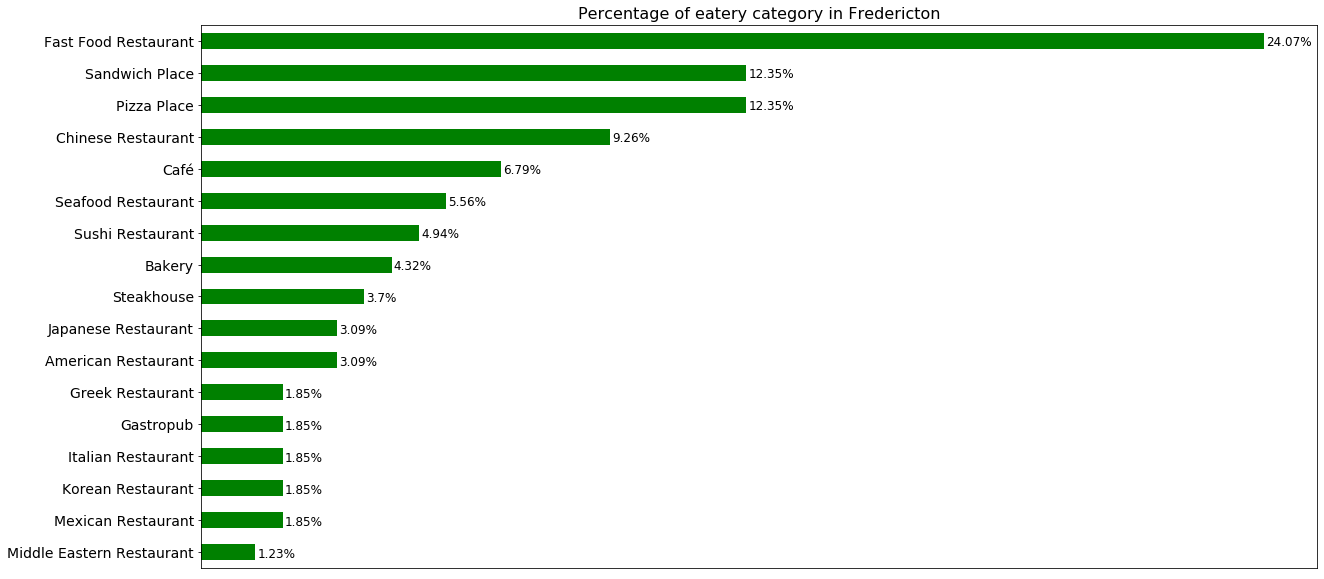

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= venue_Percent.plot(kind='barh', figsize=(20, 10),stacked=True, color='green',legend=False,fontsize=14)
ax.set_title("Percentage of eatery category in Fredericton",fontsize=16)
ax.set_facecolor(('w'))
ax.xaxis.set_visible(False)
for p in ax.patches:
    ax.annotate(str(p.get_width())+'%',(p.get_width()+.05, p.get_y()+.10),fontsize=12,color='black')
plt.show()

The bar chart shows the percentage of eatery categories in Fredericton. The percentage of each bar is shown along with itself. The graph clearly shows that Fast Food Restaurants are leading here with around 25% share. 